In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12,6)
np.random.seed(42)

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [7]:

print(f"Training data: {train.shape[0]} passengers, {train.shape[1]} features")
print(f"Test data: {test.shape[0]} passengers, {test.shape[1]} features")
print(f"Sample submission: {sample_submission.shape}")


Training data: 8693 passengers, 14 features
Test data: 4277 passengers, 13 features
Sample submission: (4277, 2)


In [8]:
train.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [9]:
print(train.dtypes)
train.describe()

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [10]:
missing = train.isnull().sum()
missing_pct = (missing / len(train) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))

              Missing Count  Percentage
CryoSleep               217        2.50
ShoppingMall            208        2.39
VIP                     203        2.34
HomePlanet              201        2.31
Name                    200        2.30
Cabin                   199        2.29
VRDeck                  188        2.16
FoodCourt               183        2.11
Spa                     183        2.11
Destination             182        2.09
RoomService             181        2.08
Age                     179        2.06


In [11]:
target_dist = train['Transported'].value_counts()
print(target_dist)
print(f"\nTransported Rate: {(target_dist[True] / len(train) * 100):.2f}%")

Transported
True     4378
False    4315
Name: count, dtype: int64

Transported Rate: 50.36%


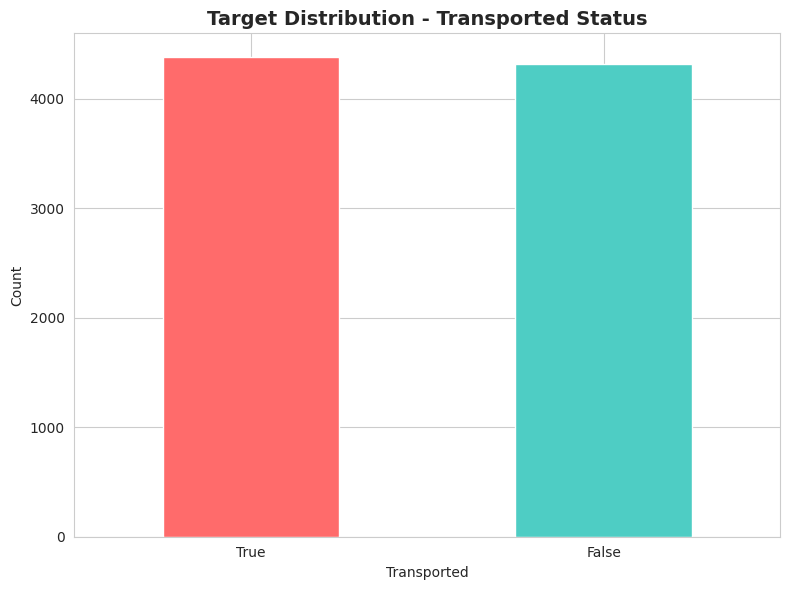

In [12]:
plt.figure(figsize=(8, 6))
target_dist.plot(kind='bar', color=['#FF6B6B', '#4ECDC4'])
plt.title('Target Distribution - Transported Status', fontsize=14, fontweight='bold')
plt.xlabel('Transported')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

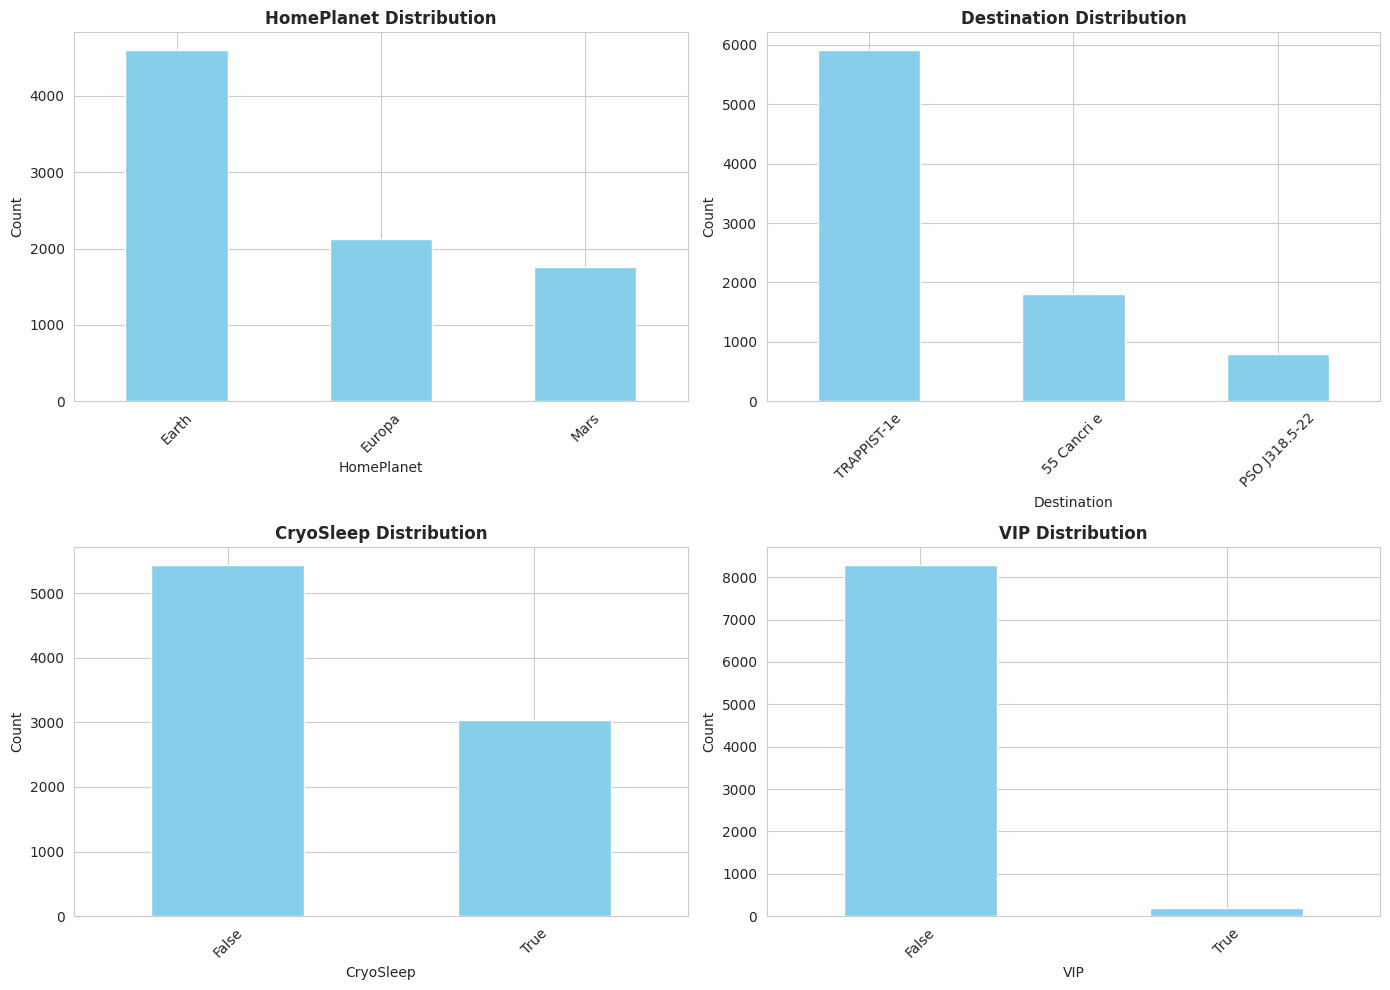

In [13]:
categorical_cols = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, col in enumerate(categorical_cols):
    if col in train.columns:
        train[col].value_counts().plot(kind='bar', ax=axes[idx], color='skyblue')
        axes[idx].set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Count')
        axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [14]:
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
print(train[spending_cols].describe())

        RoomService     FoodCourt  ShoppingMall           Spa        VRDeck
count   8512.000000   8510.000000   8485.000000   8510.000000   8505.000000
mean     224.687617    458.077203    173.729169    311.138778    304.854791
std      666.717663   1611.489240    604.696458   1136.705535   1145.717189
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.000000      0.000000      0.000000
75%       47.000000     76.000000     27.000000     59.000000     46.000000
max    14327.000000  29813.000000  23492.000000  22408.000000  24133.000000


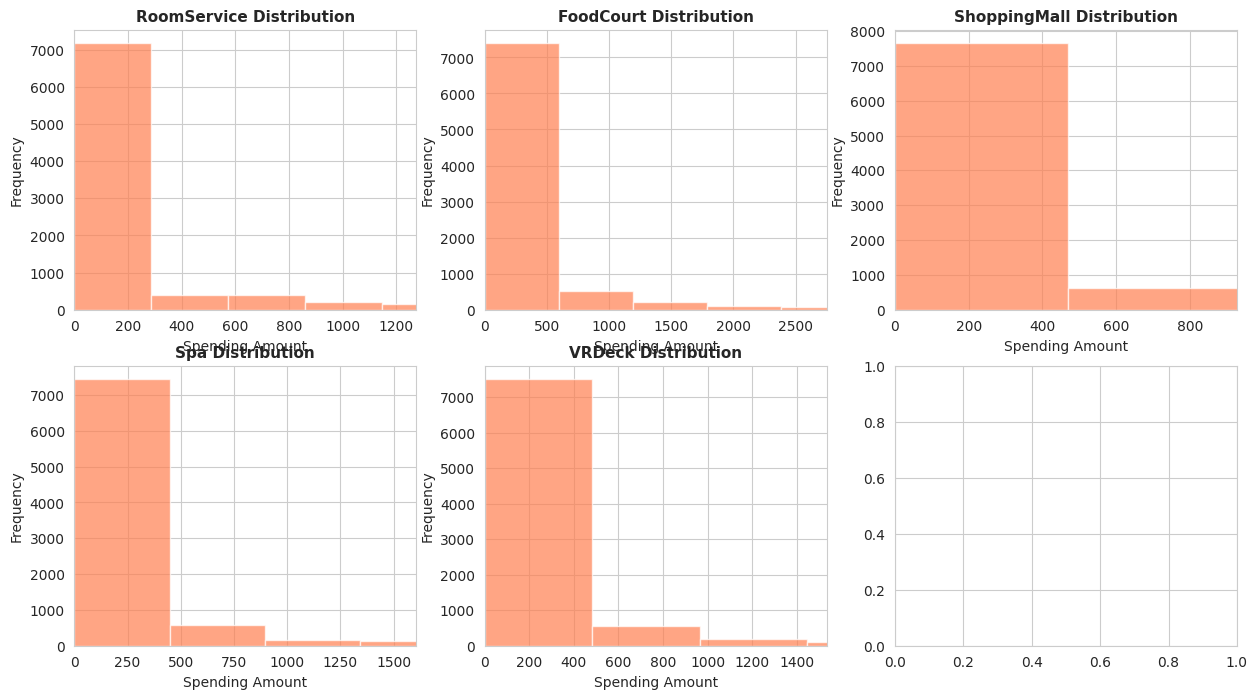

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, col in enumerate(spending_cols):
    axes[idx].hist(train[col].fillna(0), bins=50, color='coral', alpha=0.7)
    axes[idx].set_title(f'{col} Distribution', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Spending Amount')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_xlim(0, train[col].quantile(0.95))

In [16]:
train['TotalSpending'] = train[spending_cols].sum(axis=1)
axes[5].hist(train['TotalSpending'], bins=50, color='green', alpha=0.7)
axes[5].set_title('Total Spending Distribution', fontsize=11, fontweight='bold')
axes[5].set_xlabel('Total Spending Amount')
axes[5].set_ylabel('Frequency')
axes[5].set_xlim(0, train['TotalSpending'].quantile(0.95))

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

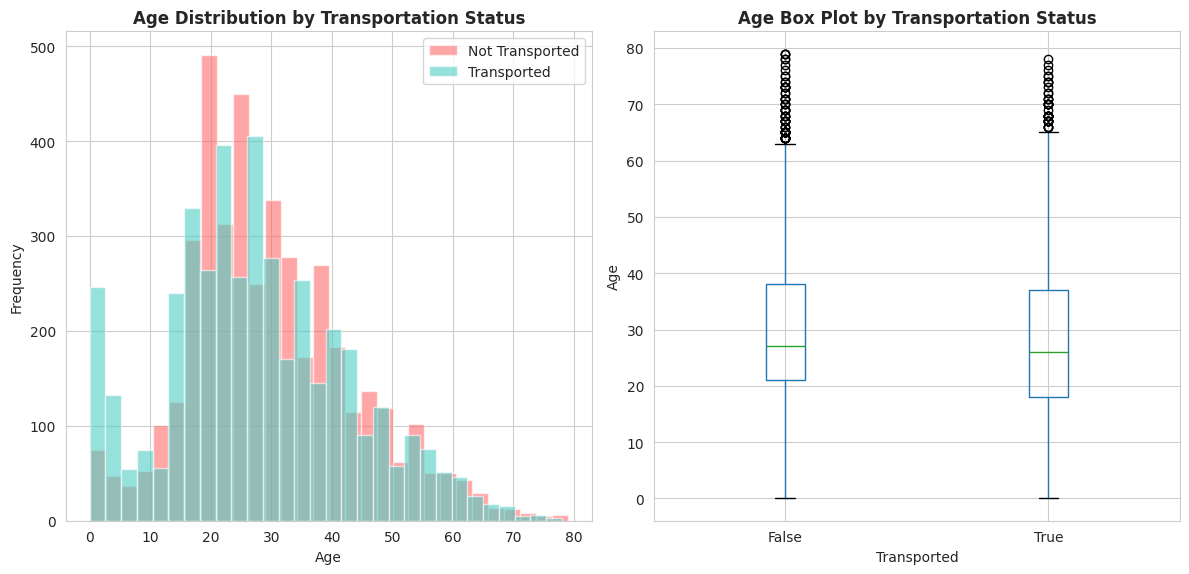

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
train[train['Transported'] == False]['Age'].hist(bins=30, alpha=0.6, color='#FF6B6B', label='Not Transported')
train[train['Transported'] == True]['Age'].hist(bins=30, alpha=0.6, color='#4ECDC4', label='Transported')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution by Transportation Status', fontweight='bold')
plt.legend()
plt.subplot(1, 2, 2)
train.boxplot(column='Age', by='Transported', ax=plt.gca())
plt.xlabel('Transported')
plt.ylabel('Age')
plt.title('Age Box Plot by Transportation Status', fontweight='bold')
plt.suptitle('')
plt.tight_layout()
plt.show()

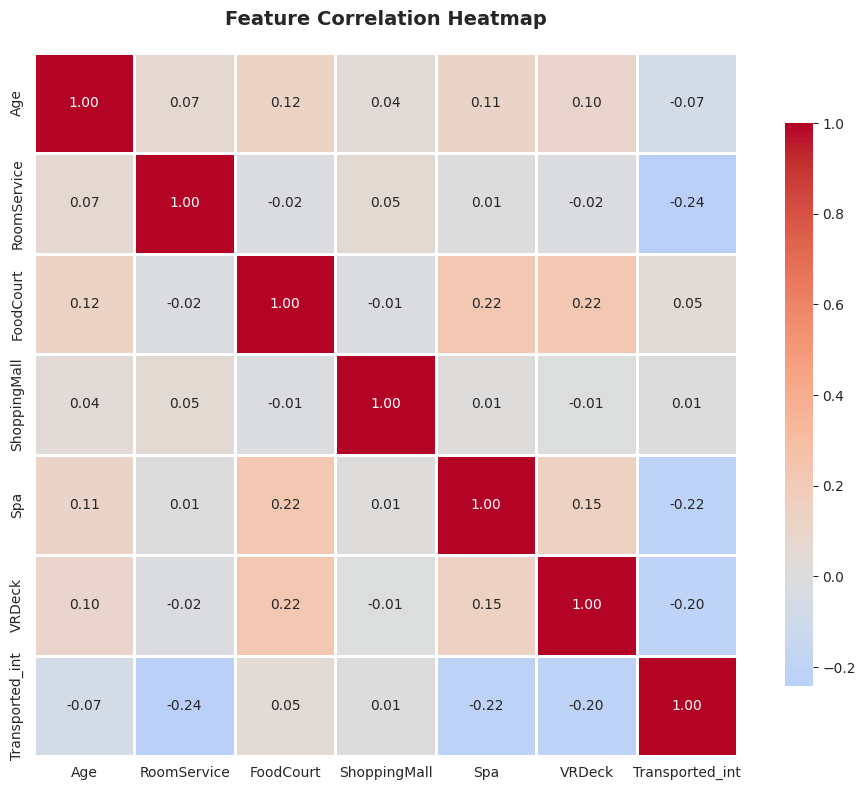

In [19]:
numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train['Transported_int'] = train['Transported'].astype(int)
corr_data = train[numeric_cols + ['Transported_int']].fillna(0)
correlation = corr_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

#Feature Engineering

In [21]:
def engineer_features(df,is_train = True):
  df = df.copy()
  df['Group'] = df['PassengerId'].apply(lambda x: x.split('_')[0])
  df['GroupSize'] = df.groupby('Group')['Group'].transform('count')
  df['IsAlone'] = (df['GroupSize'] == 1).astype(int)
  df['Deck'] = df['Cabin'].apply(lambda x: x.split('/')[0] if pd.notna(x) else 'Unknown')
  df['CabinNum'] = df['Cabin'].apply(lambda x: int(x.split('/')[1]) if pd.notna(x) else -1)
  df['Side'] = df['Cabin'].apply(lambda x: x.split('/')[2] if pd.notna(x) else 'Unknown')
  df['Surname'] = df['Name'].apply(lambda x: x.split()[-1] if pd.notna(x) else 'Unknown')
  df['FamilySize'] = df.groupby('Surname')['Surname'].transform('count')
  df['Age_Filled'] = df['Age'].fillna(df['Age'].median())
  df['IsChild'] = (df['Age_Filled'] < 13).astype(int)
  df['IsTeen'] = ((df['Age_Filled'] >= 13) & (df['Age_Filled'] < 18)).astype(int)
  df['IsAdult'] = (df['Age_Filled'] >= 18).astype(int)
  df['IsElderly'] = (df['Age_Filled'] >= 60).astype(int)
  spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
  spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
  for col in spending_cols:
      df[col] = df[col].fillna(0)

  df['TotalSpending'] = df[spending_cols].sum(axis=1)
  df['HasSpending'] = (df['TotalSpending'] > 0).astype(int)
  df['NoSpending'] = (df['TotalSpending'] == 0).astype(int)
  df['LuxurySpending'] = df['Spa'] + df['VRDeck']
  df['EssentialSpending'] = df['RoomService'] + df['FoodCourt']
  df['IsLuxurySpender'] = (df['LuxurySpending'] > df['EssentialSpending']).astype(int)
  df['ServicesUsed'] = (df[spending_cols] > 0).sum(axis=1)
  df['CryoSleep_Filled'] = df['CryoSleep'].fillna(df['NoSpending'] == 1)


  df['VIP_Filled'] = df['VIP'].fillna(False)


  df['HomePlanet_Filled'] = df['HomePlanet'].fillna(df['HomePlanet'].mode()[0])


  df['Destination_Filled'] = df['Destination'].fillna(df['Destination'].mode()[0])


  df['Planet_Destination'] = df['HomePlanet_Filled'] + '_' + df['Destination_Filled']
  df['CryoSleep_VIP'] = df['CryoSleep_Filled'].astype(str) + '_' + df['VIP_Filled'].astype(str)


  deck_mapping = {'A': 'Front', 'B': 'Front', 'C': 'Front',
                   'D': 'Middle', 'E': 'Middle', 'F': 'Middle',
                   'G': 'Back', 'T': 'Special', 'Unknown': 'Unknown'}
  df['DeckRegion'] = df['Deck'].map(deck_mapping)

  print(f"Created {len(df.columns) - (14 if is_train else 13)} new features")
  print(f"Total features: {len(df.columns)}")
  return df
train_fe = engineer_features(train, is_train=True)
test_fe = engineer_features(test, is_train=False)

print("\nFeature engineering complete!")
print(f"Training data shape: {train_fe.shape}")
print(f"Test data shape: {test_fe.shape}")

Created 28 new features
Total features: 42
Created 27 new features
Total features: 40

Feature engineering complete!
Training data shape: (8693, 42)
Test data shape: (4277, 40)


In [22]:
def prepare_features(train_df, test_df):
    numeric_features = [
        'Age_Filled', 'GroupSize', 'FamilySize', 'CabinNum',
        'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
        'TotalSpending', 'LuxurySpending', 'EssentialSpending', 'ServicesUsed',
        'IsChild', 'IsTeen', 'IsAdult', 'IsElderly',
        'IsAlone', 'HasSpending', 'NoSpending', 'IsLuxurySpender'
    ]
    categorical_features = [
        'HomePlanet_Filled', 'Destination_Filled', 'Deck', 'Side',
        'CryoSleep_Filled', 'VIP_Filled', 'DeckRegion',
        'Planet_Destination', 'CryoSleep_VIP'
    ]
    train_encoded = pd.get_dummies(train_df[categorical_features], drop_first=True)
    test_encoded = pd.get_dummies(test_df[categorical_features], drop_first=True)
    train_encoded, test_encoded = train_encoded.align(test_encoded, join='left', axis=1, fill_value=0)
    X_train = pd.concat([
        train_df[numeric_features].reset_index(drop=True),
        train_encoded.reset_index(drop=True)
    ], axis=1)

    X_test = pd.concat([
        test_df[numeric_features].reset_index(drop=True),
        test_encoded.reset_index(drop=True)
    ], axis=1)

    y_train = train_df['Transported'].astype(int)

    print(f"Training features shape: {X_train.shape}")
    print(f"Test features shape: {X_test.shape}")
    print(f"Number of features: {X_train.shape[1]}")

    return X_train, X_test, y_train
X_train, X_test, y_train = prepare_features(train_fe, test_fe)

print("\nFeatures prepared successfully!")

Training features shape: (8693, 52)
Test features shape: (4277, 52)
Number of features: 52

Features prepared successfully!


#Model Training

In [23]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set: {X_tr.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

Training set: 6954 samples
Validation set: 1739 samples


In [24]:
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        min_samples_split=8,
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        min_samples_split=8,
        min_samples_leaf=4,
        subsample=0.8,
        random_state=42
    ),
    'LogisticRegression': LogisticRegression(
        max_iter=2000,
        C=0.5,
        solver='lbfgs',
        random_state=42
    )
}

print("Models defined:")
for name in models.keys():
    print(f"  - {name}")

Models defined:
  - RandomForest
  - GradientBoosting
  - LogisticRegression


In [26]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}
best_score = 0
best_model_name = None
for name, model in models.items():
  cv_scores = cross_val_score(model, X_tr, y_tr, cv=cv, scoring='accuracy', n_jobs = 1)
  print(f"Cv scores: {cv_scores}")
  print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/-{cv_scores.std():.4f})")
  model.fit(X_tr, y_tr)
  y_pred = model.predict(X_val)
  val_accuracy = accuracy_score(y_val, y_pred)
  print(f"Validation Accuracy: {val_accuracy:.4f}")

  results[name] = {
      'model': model,
      'cv_mean': cv_scores.mean(),
      'cv_std': cv_scores.std(),
      'val_accuracy': val_accuracy
  }

  if val_accuracy > best_score:
      best_score = val_accuracy
      best_model_name = name


Cv scores: [0.80445723 0.80517613 0.79942487 0.78648454 0.80359712]
Mean CV accuracy: 0.7998 (+/-0.0070)
Validation Accuracy: 0.8051
Cv scores: [0.80661395 0.80661395 0.80661395 0.79870597 0.80647482]
Mean CV accuracy: 0.8050 (+/-0.0031)
Validation Accuracy: 0.8154
Cv scores: [0.78576564 0.7922358  0.79654925 0.78432782 0.79568345]
Mean CV accuracy: 0.7909 (+/-0.0050)
Validation Accuracy: 0.7895


In [27]:
ensemble = VotingClassifier(
    estimators=[(name, results[name]['model']) for name in models.keys()],
    voting='soft',
    n_jobs=-1
)
ensemble.fit(X_tr, y_tr)
y_pred_ensemble = ensemble.predict(X_val)
ensemble_accuracy = accuracy_score(y_val, y_pred_ensemble)
print(f"Ensemble Validation Accuracy: {ensemble_accuracy:.4f}")
results['Ensemble'] = {
    'model': ensemble,
    'val_accuracy': ensemble_accuracy
}
if ensemble_accuracy > best_score:
    best_score = ensemble_accuracy
    best_model_name = 'Ensemble'

print(f"\nBest Model: {best_model_name} (Accuracy: {best_score:.4f})")

Ensemble Validation Accuracy: 0.8028

Best Model: GradientBoosting (Accuracy: 0.8154)


In [28]:
results_df = pd.DataFrame([
    {
        'Model': name,
        'CV Mean': data.get('cv_mean', np.nan),
        'CV Std': data.get('cv_std', np.nan),
        'Validation Accuracy': data['val_accuracy']
    }
    for name, data in results.items()
])
results_df = results_df.sort_values('Validation Accuracy', ascending=False)
print(results_df.to_string(index=False))

             Model  CV Mean   CV Std  Validation Accuracy
  GradientBoosting 0.805005 0.003150             0.815411
      RandomForest 0.799828 0.006963             0.805060
          Ensemble      NaN      NaN             0.802760
LogisticRegression 0.790912 0.005023             0.789534


                 Feature  Importance
          LuxurySpending    0.085425
           TotalSpending    0.072914
            ServicesUsed    0.064871
             RoomService    0.061065
       EssentialSpending    0.059900
             HasSpending    0.055659
              NoSpending    0.054586
               FoodCourt    0.049587
                CabinNum    0.045844
         IsLuxurySpender    0.044569
CryoSleep_VIP_True_False    0.041780
            ShoppingMall    0.040884
                     Spa    0.038333
                  VRDeck    0.035443
        CryoSleep_Filled    0.031827


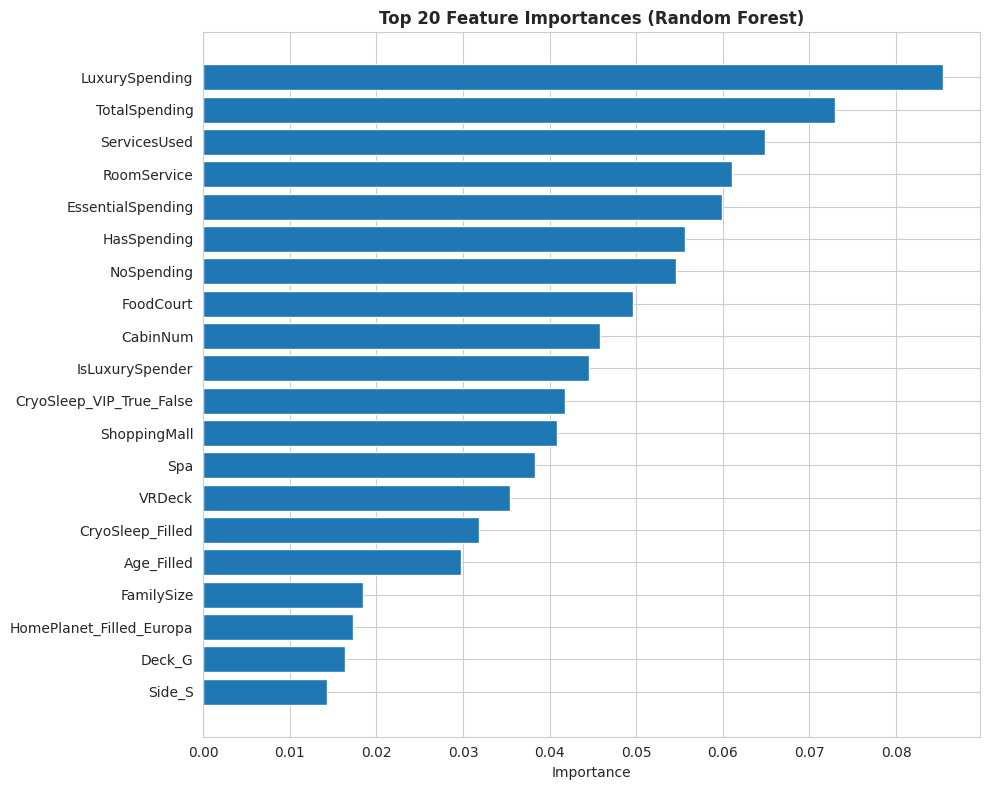

In [29]:
if 'RandomForest' in results:
    rf_model = results['RandomForest']['model']
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    print(feature_importance.head(15).to_string(index=False))
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance')
    plt.title('Top 20 Feature Importances (Random Forest)', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [30]:
best_model = results[best_model_name]['model']

print("Retraining best model on full training data...")
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)
print(f"\nGenerated {len(predictions)} predictions")
print(f"Transported: {predictions.sum()} ({predictions.sum()/len(predictions)*100:.2f}%)")
print(f"Not Transported: {(~predictions.astype(bool)).sum()} ({(~predictions.astype(bool)).sum()/len(predictions)*100:.2f}%)")

Retraining best model on full training data...

Generated 4277 predictions
Transported: 2145 (50.15%)
Not Transported: 2132 (49.85%)


In [31]:
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Transported': predictions.astype(bool)
})
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")
print("\nFirst 10 predictions:")
print(submission.head(10))
print("\nLast 10 predictions:")
print(submission.tail(10))

Submission file created: submission.csv

First 10 predictions:
  PassengerId  Transported
0     0013_01        False
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True
5     0027_01        False
6     0029_01         True
7     0032_01         True
8     0032_02         True
9     0033_01        False

Last 10 predictions:
     PassengerId  Transported
4267     9260_01         True
4268     9262_01         True
4269     9263_01         True
4270     9265_01         True
4271     9266_01         True
4272     9266_02         True
4273     9269_01        False
4274     9271_01         True
4275     9273_01         True
4276     9277_01        False
